# Pairs Trading Algorithm
Pairs trading is a market-neutral trading strategy that involves matching a long position with a short position in two stocks that have a high correlation.

In [869]:
# imports
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

In [870]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

*get_pairs_cointegrated* function runs the cointegration test on all the pairs of tickers in a dataframe

In [871]:
# gets the p_value for different pairs and identifies the extent of cointegration
def get_pairs_cointegrated(data):
    pairs = []
    n = data.shape[1]
    score_mat = np.zeros((n,n))
    pvalue_mat = np.ones((n,n))
    key = data.keys()
    for i in range(n):
        for j in range(i+1,n):
            X = data[key[i]]
            Y = data[key[j]]
            res = coint(X, Y)
            score = res[0]
            pvalue = res[1]
            score_mat[i, j] = score
            pvalue_mat[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((key[i],key[j]))
    return score_mat,pvalue_mat,pairs

In [872]:
# function for finding the zscore of a timeseries
def zscore(timeseries):
    return (timeseries - timeseries.mean())/np.std(timeseries)

In [873]:
# fetching data from yfinance library
end = datetime.datetime(2024,1,1)
start = datetime.datetime(2015,1,1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY','NVDA','GOOG','TSLA','JPM','BAC']

df = pdr.get_data_yahoo(tickers,start,end)
df = df["Close"]

[*********************100%%**********************]  16 of 16 completed


In [874]:
scores,pvalues,pairs = get_pairs_cointegrated(df)

In [875]:
pairs

[('AAPL', 'AMD'),
 ('AMD', 'GOOG'),
 ('AMD', 'MSFT'),
 ('AMD', 'SPY'),
 ('GOOG', 'SPY'),
 ('GOOG', 'TSLA'),
 ('IBM', 'JPM'),
 ('IBM', 'MSFT'),
 ('IBM', 'ORCL'),
 ('IBM', 'QCOM'),
 ('IBM', 'SPY'),
 ('IBM', 'TSLA'),
 ('JNPR', 'JPM'),
 ('JNPR', 'MSFT'),
 ('JNPR', 'NVDA'),
 ('JNPR', 'ORCL'),
 ('JNPR', 'QCOM'),
 ('JNPR', 'SPY'),
 ('JNPR', 'TSLA'),
 ('QCOM', 'TSLA')]

<Axes: >

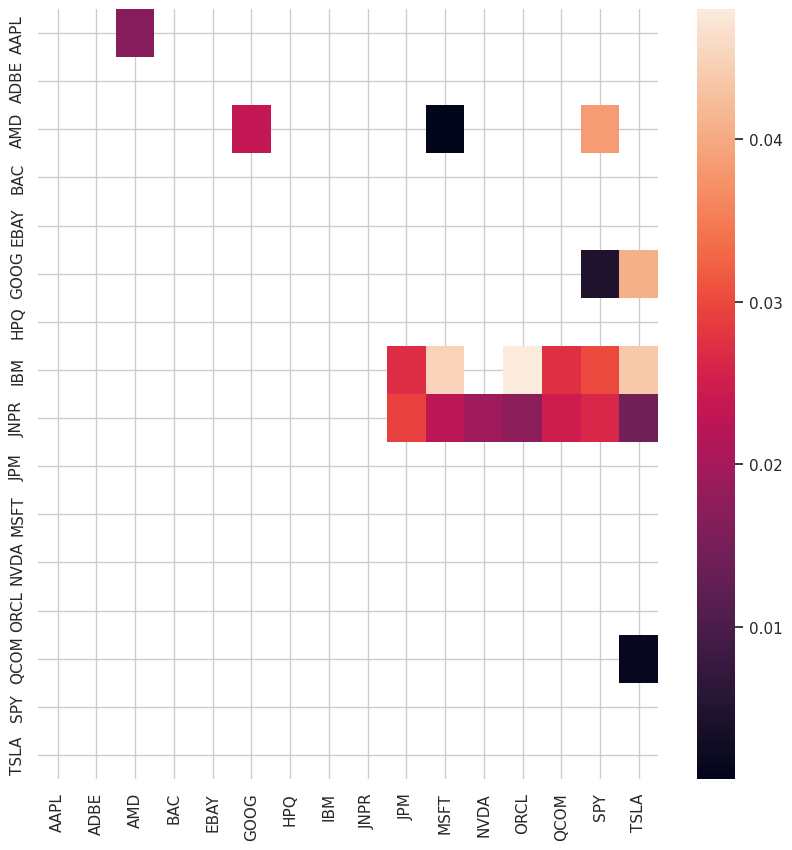

In [876]:
# plotting the pvalue heatmap for the stocks fetched
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, mask = (pvalues >= 0.05))

In [877]:
for p in pairs:
    score,pvalue,_ = coint(df[p[0]],df[p[1]])
    print(p,pvalue,sep = " | ")

('AAPL', 'AMD') | 0.016815930157808762
('AMD', 'GOOG') | 0.023368928205873895
('AMD', 'MSFT') | 0.0006273864310144294
('AMD', 'SPY') | 0.038543521037726715
('GOOG', 'SPY') | 0.004421337514473937
('GOOG', 'TSLA') | 0.04071710306996942
('IBM', 'JPM') | 0.027019275247765966
('IBM', 'MSFT') | 0.045013537753869154
('IBM', 'ORCL') | 0.04800072617009323
('IBM', 'QCOM') | 0.027411680107217107
('IBM', 'SPY') | 0.029869654764490872
('IBM', 'TSLA') | 0.043699992724258105
('JNPR', 'JPM') | 0.028980549184719942
('JNPR', 'MSFT') | 0.02270883488085717
('JNPR', 'NVDA') | 0.019230316986691483
('JNPR', 'ORCL') | 0.017287943784046772
('JNPR', 'QCOM') | 0.024585276160836497
('JNPR', 'SPY') | 0.026224043888506143
('JNPR', 'TSLA') | 0.014236011170940116
('QCOM', 'TSLA') | 0.0014342245022822245


Change the **str1** and **str2** variables to test the notebook for different stocks

In [878]:
str1 = 'QCOM'
str2 = 'TSLA'

In [879]:
stock1 = df[str1]
stock2 = df[str2]

score,pvalue,_ = coint(stock1,stock2)

In [880]:
pvalue

0.0014342245022822245

Run **OLS** only when using the spread of the stock prices, not needed when using the price ratios

In [881]:
# OLS (Linear Regression) needs to be applied when calculating spread
stock1 = sm.add_constant(stock1)
results = sm.OLS(stock2,stock1).fit()
stock1

,const,QCOM
Date,,
2015-01-02,1.0,74.279999
2015-01-05,1.0,73.930000
2015-01-06,1.0,72.879997
2015-01-07,1.0,73.730003
2015-01-08,1.0,74.510002
...,...,...
2023-12-22,1.0,143.490005
2023-12-26,1.0,145.460007
2023-12-27,1.0,145.720001


In [882]:
stock1 = stock1[str1]

In [883]:
b = results.params[str1]

## Different plots

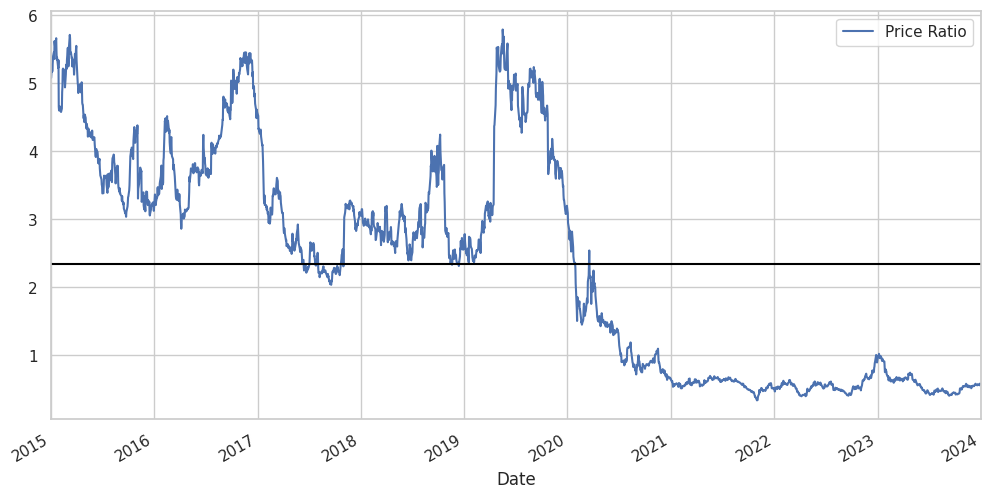

In [884]:
#plot for ratio of the two stocks
ratio = stock1/stock2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2015-01-01', '2024-01-01')
plt.legend(['Price Ratio']);

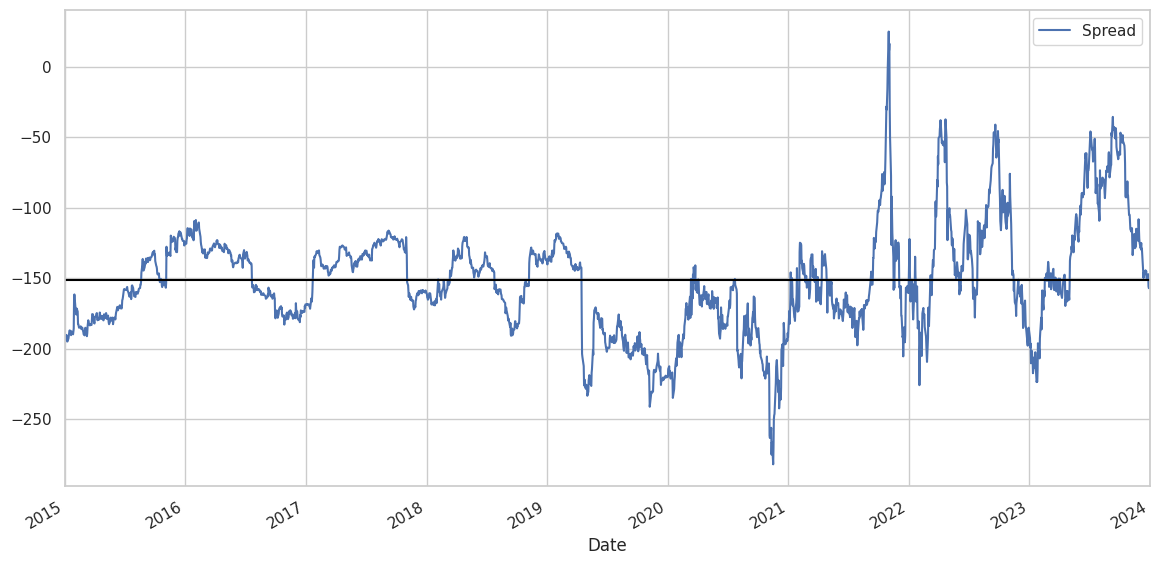

In [885]:
#plot for the spread of the two stock prices
spread = stock2 - b*stock1
spread.plot(figsize = (14,7))
plt.axhline(spread.mean(),color = 'black')
plt.xlim('2015-01-01','2024-01-01')
plt.legend(['Spread'])

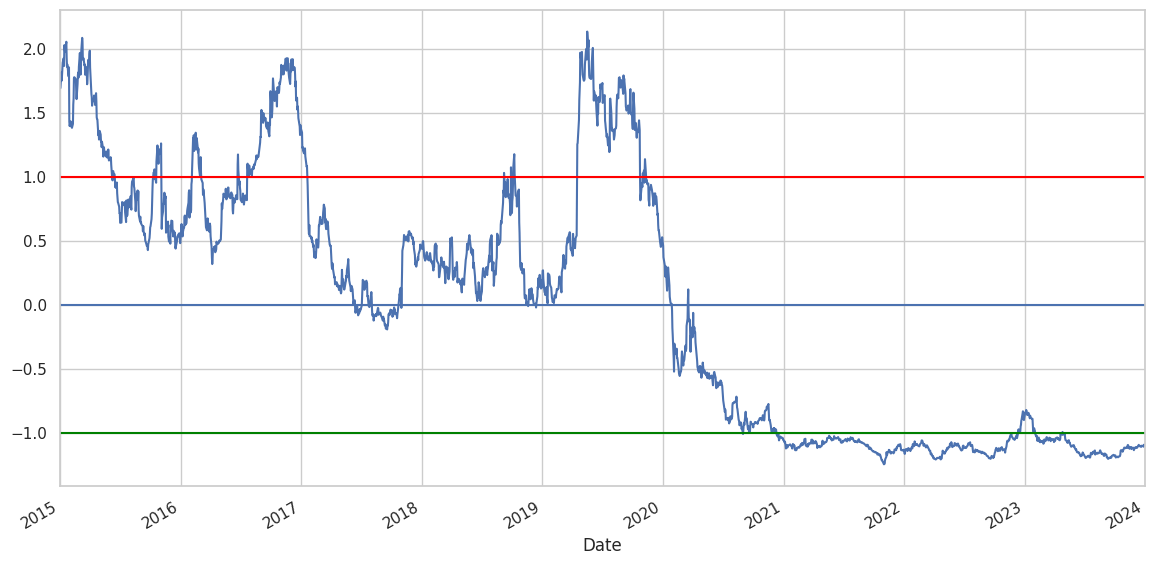

In [886]:
# zscore plot for the ratios time series
zscore(ratio).plot(figsize=(14,7))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2015-01-01', '2024-01-01')
plt.show()

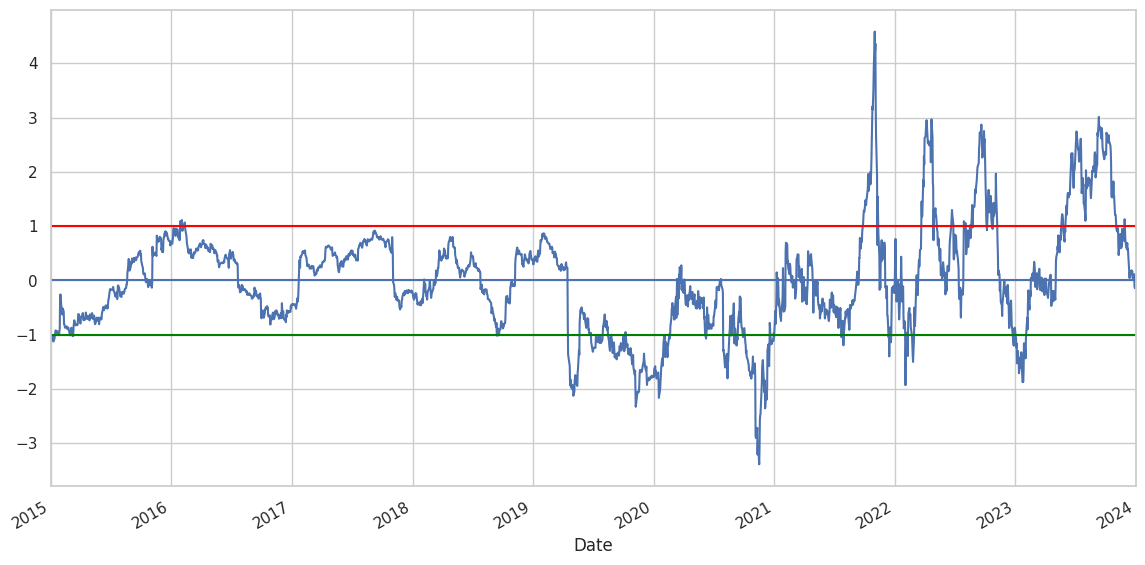

In [887]:
zscore(spread).plot(figsize=(14,7))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2015-01-01', '2024-01-01')
plt.show()

### Train Test Split

In [888]:
# splitting the data into test and train (test-train split)
ratios = df[str1] / df[str2] 
sz = len(ratios) * 0.70
sz = int(sz)
print(sz)

1584


In [889]:
train = ratios[:sz]
test = ratios[sz:]

In [890]:
# calculates moving averages, standard deviation, zscore
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60

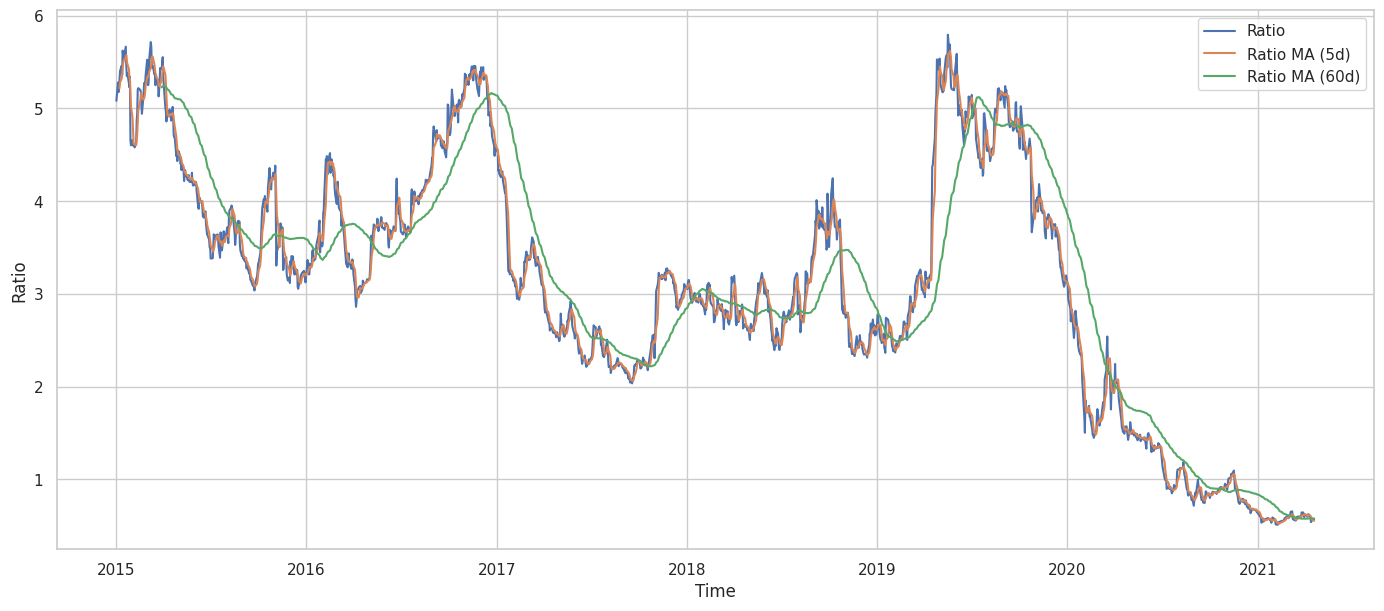

In [891]:
plt.figure(figsize=(17, 7))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', 'Ratio MA (5d)', 'Ratio MA (60d)'])

plt.ylabel('Ratio')
plt.xlabel('Time')
plt.show()

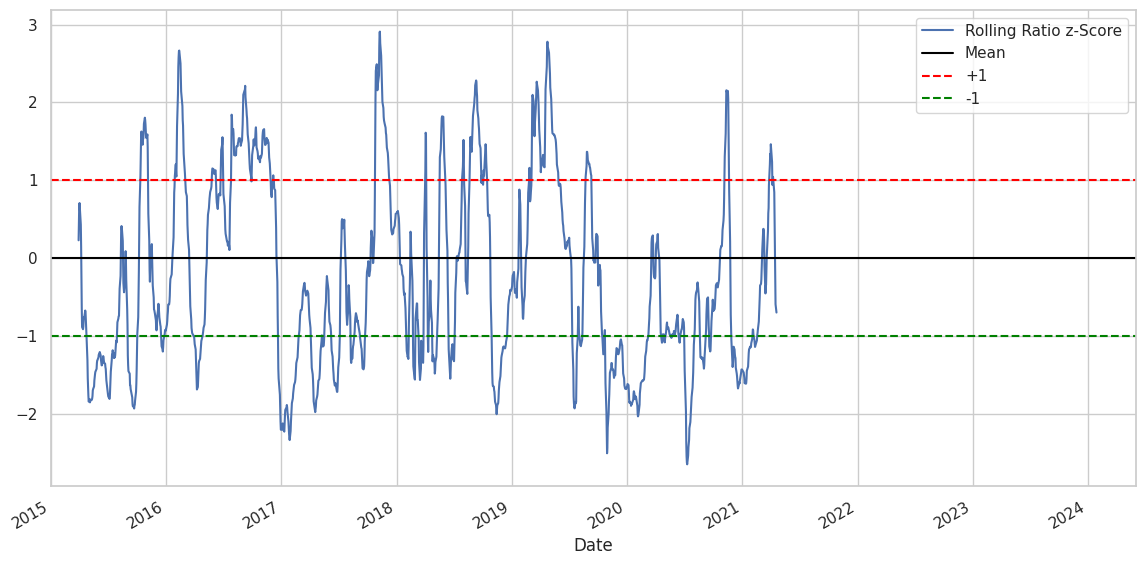

In [892]:
# plot for z-score
plt.figure(figsize=(14,7))
zscore_60_5.plot()
plt.xlim('2015-01-01', '2024-06-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

In [893]:
zscore_60_5

Date
2015-01-02         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
                ...   
2021-04-13    0.501563
2021-04-14    0.084662
2021-04-15   -0.236107
2021-04-16   -0.593600
2021-04-19   -0.700070
Length: 1584, dtype: float64

In [894]:
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0

In [895]:
buy

Date
2015-01-02    5.080479
2015-01-05    5.278452
2015-01-06    5.174176
2015-01-07    5.242712
2015-01-08    5.306476
                ...   
2021-04-13    0.000000
2021-04-14    0.000000
2021-04-15    0.000000
2021-04-16    0.000000
2021-04-19    0.000000
Length: 1584, dtype: float64

In [896]:
sell

Date
2015-01-02    5.080479
2015-01-05    5.278452
2015-01-06    5.174176
2015-01-07    5.242712
2015-01-08    5.306476
                ...   
2021-04-13    0.000000
2021-04-14    0.000000
2021-04-15    0.000000
2021-04-16    0.000000
2021-04-19    0.000000
Length: 1584, dtype: float64

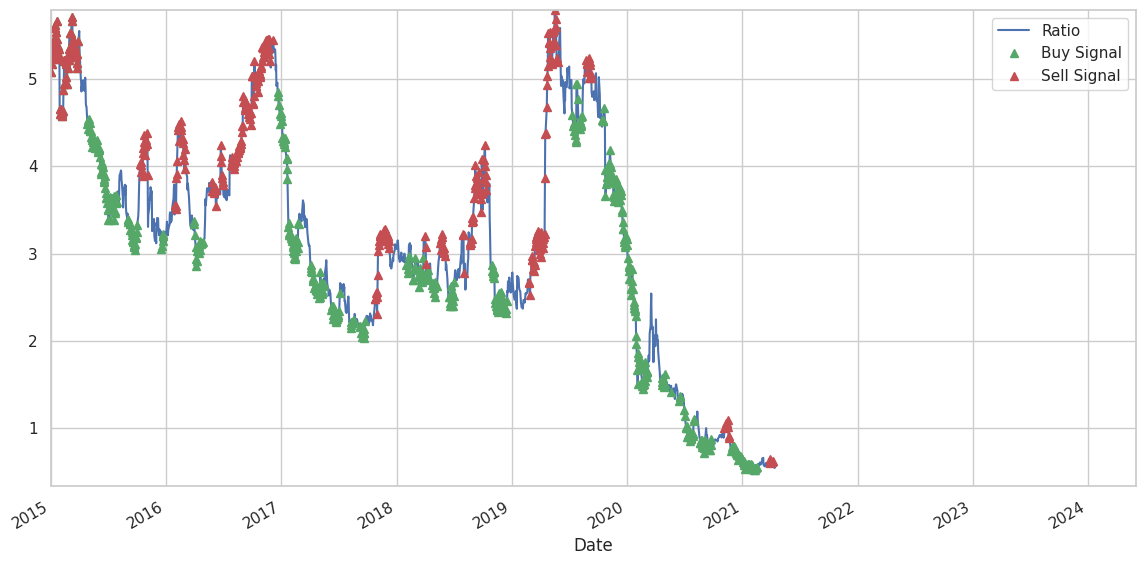

In [897]:
# buy/sell signals plotted on the ratio of both the stock prices
plt.figure(figsize=(14,7))
train.plot()
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2015-01-01','2024-06-01')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

### Visualisation of Buy/Sell signals on each stock

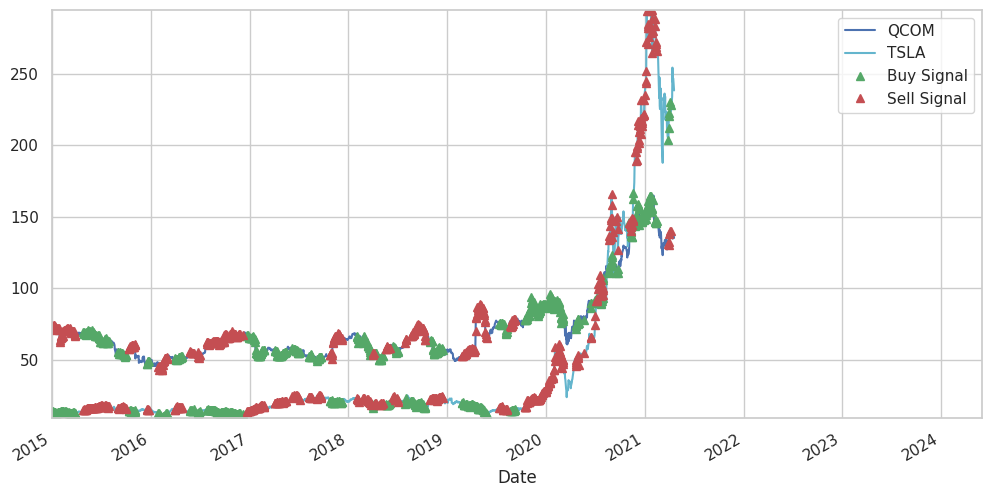

In [898]:
# plot for buy and sell signals for both stocks individually
plt.figure(figsize=(12,6))
S1 = df[str1].iloc[:sz]
S2 = df[str2].iloc[:sz]
S1.plot(color='b')
S2.plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR.plot(color='g', linestyle='None', marker='^')
sellR.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.xlim('2015-01-01', '2024-06-01')

plt.legend([str1, str2, 'Buy Signal', 'Sell Signal'])
plt.show()

In [899]:
# gets rid of deprecation warnings
import warnings
warnings.filterwarnings('ignore')

### Trade Simulation Function
Use this function to simulate the strategy, adjust parameters using the **optimize_parameters** function below

In [900]:
# used to simulate the strategy with the input parameters on stock1 and stock2
def trade(stock1, stock2, window1, window2, transaction_cost=0, stop_loss=0.05, take_profit=0.10):
    if window1 == 0 or window2 == 0:
        return 0

    ratios = stock1 / stock2
    mv_avg1 = ratios.rolling(window=window1, center=False).mean()
    mv_avg2 = ratios.rolling(window=window2, center=False).mean()
    stdev = ratios.rolling(window=window2, center=False).std()
    zscore = (mv_avg1 - mv_avg2) / stdev

    money = 0
    cnt_st1 = 0
    cnt_st2 = 0
    position_open = False
    entry_money = 0

    for i in range(len(ratios)):
        if zscore[i] < -1 and not position_open:
            # Buy stock1 and sell stock2
            entry_money = money
            money -= stock1[i] + transaction_cost
            money += stock2[i] * ratios[i] - transaction_cost
            cnt_st1 += 1
            cnt_st2 -= ratios[i]
            position_open = True

        elif zscore[i] > 1 and not position_open:
            # Sell stock1 and buy stock2
            entry_money = money
            money += stock1[i] - transaction_cost
            money -= stock2[i] * ratios[i] + transaction_cost
            cnt_st1 -= 1
            cnt_st2 += ratios[i]
            position_open = True

        elif position_open:
            current_money = money + cnt_st1 * stock1[i] + cnt_st2 * stock2[i]
            profit_loss = current_money - entry_money
            if abs(zscore[i]) < 0.75 or profit_loss <= -stop_loss * entry_money or profit_loss >= take_profit * entry_money:
                # Close positions
                money += cnt_st1 * stock1[i] - transaction_cost
                money += cnt_st2 * stock2[i] - transaction_cost
                cnt_st1 = 0
                cnt_st2 = 0
                position_open = False

    # Final close of positions
    money += cnt_st1 * stock1.iloc[-1]
    money += cnt_st2 * stock2.iloc[-1]
    
    return money

profit = trade(df[str1].iloc[sz:], df[str2].iloc[sz:], 30, 5, transaction_cost=0, stop_loss=0.05, take_profit=0.10)
profit

69.757397960363

### Optimize Parameters Function

In [901]:
# used to find the appropriate values for window1 and window2 parameters
def optimize_parameters(stock1, stock2):
    best_profit = -np.inf
    best_params = (0, 0)

    for window1 in range(10, 100, 10):
        for window2 in range(5, 50, 5):
            if(window1<window2):
                continue
            profit = trade(stock1, stock2, window1, window2, transaction_cost=0, stop_loss=0.05, take_profit=0.10)
            if profit > best_profit:
                best_profit = profit
                best_params = (window1, window2)

    return best_params, best_profit

# Example usage
best_params, best_profit = optimize_parameters(df[str1].iloc[sz:], df[str2].iloc[sz:])
best_params, best_profit

((20, 5), 170.44471321179708)